## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
torch.set_default_dtype(torch.float64) 
sys.modules['dostools.src'] = dostools

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


## Evaluator

In [3]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Dataset and DataLoader

In [126]:
import dostools.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader
import dostools.consistency.consistency as consistency

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
y_shifted = copy.deepcopy(ldos)
#y_shifted[train_index[0]] = consistency.shifted_ldos(y_shifted[train_index[0]], xdos, torch.zeros(1)-1)
#y_shifted[:100] = consistency.shifted_ldos(y_shifted[:100], xdos, torch.zeros(100)-10)
train_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][train_index].double(), y_shifted[train_index].double())
train_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][train_index].double(), y_shifted[train_index].double())

test_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_shifted[test_index].double())
test_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_shifted[test_index].double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = n_train, shuffle = False, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = n_train, shuffle = False, **kwargs)



In [48]:
xdos_step = xdos[1] - xdos[0]

print (1/xdos_step)

tensor(19.9742)


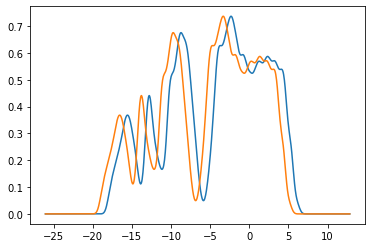

In [49]:
plt.plot(xdos, ldos[0])
plt.plot(xdos,y_shifted[0])

## Loss Function

In [20]:
def t_get_jitter_mse(prediction, true, shifts, shift_interval, xdos = None, perc = False):
    if xdos is not None:
        mse = torch.zeros(true.shape[0])
        new_shifts = torch.zeros_like(shifts)
        xdos_step = xdos[1] - xdos[0]
        shift_range = torch.clamp(torch.vstack([shifts + x for x in range(-1*shift_interval, shift_interval +1)]).T, -778, 778)* xdos_step
        if perc:
            mean = true.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((true - mean)**2, xdos, axis=1)).mean()
        else:
            std = None
        for i, pred in enumerate(prediction):
            shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[1],1), xdos, shift_range[i])
            mse[i], index = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[1],1), xdos = xdos, perc = perc, std_dev = std),0)
            new_shifts[i] = shift_range[i][index]
        
        mse = torch.mean(mse, 0)  
                                    
        return mse, new_shifts/xdos_step
    else:
        raise ValueError("xdos not defined")

In [21]:
import dostools.src.consistency.consistency as consistency
import dostools.src.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_BF_shift_index_mse(prediction, true, shift_range, xdos = None, perc = False):
    if xdos is not None:
        mse = torch.zeros(true.shape[0])
        index = torch.zeros(true.shape[0])
        for i, pred in enumerate((prediction)):
            shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[0],1), xdos, shift_range)
            mse[i], index[i] = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[0],1)),0)
        mse = torch.mean(mse, 0)
        
        return mse,index        
    else:
        raise ValueError("xdos not defined")


## Evaluation Function

In [14]:
def t_get_opt_BF_shift_rmse(prediction, true, opt_shift, xdos = None, perc = False):
    if xdos is not None:
        rmse = torch.zeros(true.shape[0])
        index = torch.zeros(true.shape[0])
        shifted_preds = consistency.shifted_ldos(prediction, xdos, opt_shift)
        rmse = torch.sqrt(torch.trapezoid((shifted_preds - true)**2, xdos, axis = 1)).mean()

        if perc:
            mean = true.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((true - mean)**2, xdos, axis = 1)).mean()
            loss = (100 * rmse/std)
        return loss        
    else:
        raise ValueError("xdos not defined")

## Alignment Model

In [211]:
import dostools.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader
import dostools.consistency.consistency as consistency

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
y_shifted = copy.deepcopy(ldos)
#y_shifted[train_index[0]] = consistency.shifted_ldos(y_shifted[train_index[0]], xdos, torch.zeros(1)-1)
#y_shifted[:100] = consistency.shifted_ldos(y_shifted[:100], xdos, torch.zeros(100)-10)
train_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][train_index].double(), y_shifted[train_index].double())
train_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][train_index].double(), y_shifted[train_index].double())

test_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_shifted[test_index].double())
test_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_shifted[test_index].double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = n_train, shuffle = False, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = n_train, shuffle = False, **kwargs)



In [212]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)


class AlignmentLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, train_size, xdos, reg, opt, device):
        super(AlignmentLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = True)
        self.xdos = xdos
        self.opt = opt
        self.device = device
        self.reg = torch.tensor(reg, requires_grad = False).to(self.device)
        #self.alignment = torch.zeros(train_size, device = self.device)
        self.zeroalignment = 0
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out


In [213]:
import matplotlib
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

xdos_step = xdos[1] - xdos[0]
#shift_range = torch.tensor([x*xdos_step for x in range(-20,20)])
M_soap = AlignmentLinearModel(448, 778, n_train, xdos, 1e-11, "LBFGS", "cpu")
#loss_history = M_soap.fit(train_dataloader_soap,None, None, 1, 20000)

### Normal training

  0%|                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


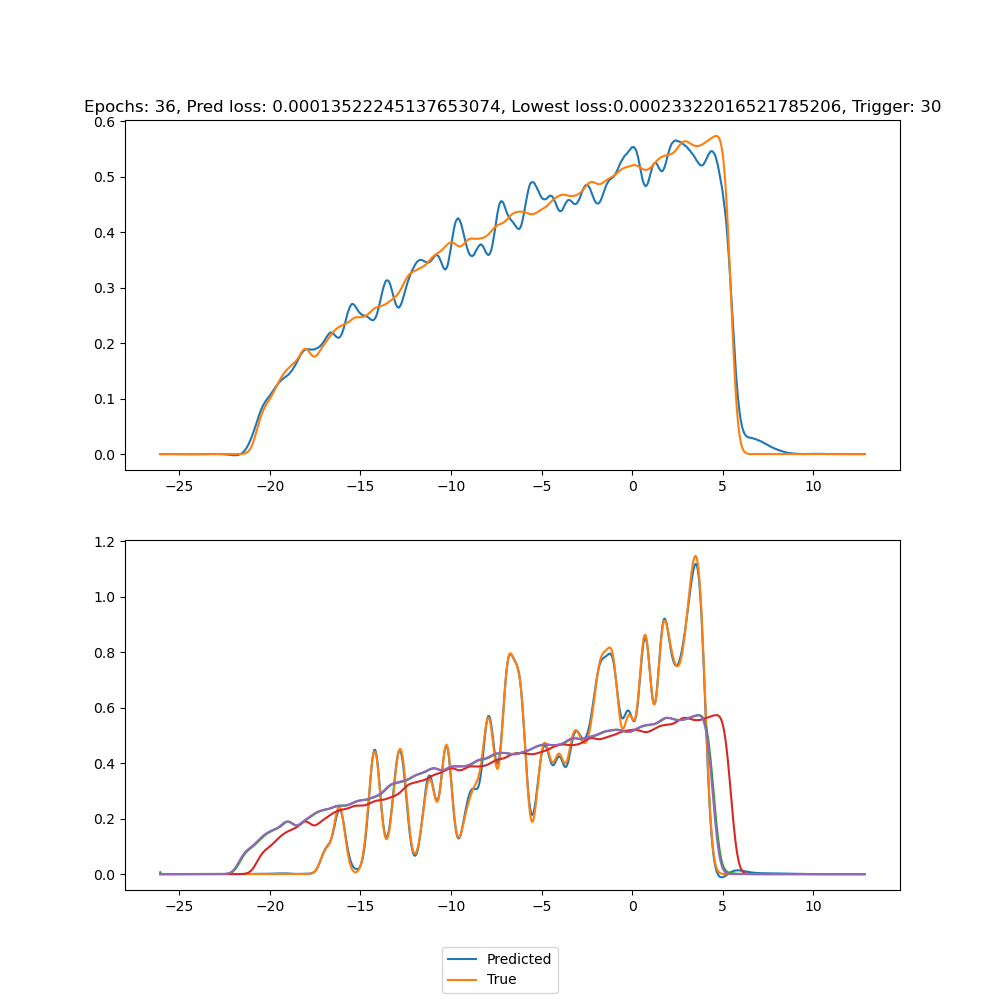

Epoch: 36:  36%|████████████████████████████████████                                                                | 36/100 [00:44<01:18,  1.23s/it, lowest_loss=0.000233, pred_loss=0.000133, trigger=30]

Implemented early stopping with lowest_loss: 0.00023322016521785206


In [214]:
lr = 1
n_epochs = 100
traindata_loader = train_dataloader_soap

opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)

threshold = 30
scheduler_threshold = 5
tol = 1e-4


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
best_state = copy.deepcopy(M_soap.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))
fig, ax_list = plt.subplots(2,1)
critical_indexes = np.array([0,1])
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
ax_list = ax_list.flatten()
ax_list.flatten()
lines = []
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "Prediction")
    lines.append(line)
    ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "True")
fig.legend(labels = ["Predicted", "True"], loc = "lower center")
fig.show()
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in traindata_loader:
        opt.zero_grad()
        x_data, y_data = x_data.to(M_soap.device), y_data.to(M_soap.device)
        def closure(predictions = False):
            """
            Function is necessary for LBFGS, returns the total loss of the model

            Args:
                predictions (bool, optional): Returns prediction loss if true, returns total loss if False

            Returns:
                tensor: Loss
            """
            opt.zero_grad()
            _pred = M_soap.forward(x_data)
            _pred_loss = loss.t_get_mse(_pred, y_data)#, self.xdos), perc = True)       
            _pred_loss *= 1e7
            #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
            _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
            _reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
            _reg_loss *= M_soap.reg.item()
            _new_loss = _pred_loss + _reg_loss
            _new_loss.backward()
            # global z 
            # z = (torch.sum(abs(self.linear.weight.grad)))
            if predictions:
                return _pred_loss
            return _new_loss
        opt.step(closure)
            #print (z)
    with torch.no_grad():
        pred = M_soap.forward(x_data)
        pred_loss = loss.t_get_mse(pred, y_data)#, self.alignment, self.xdos, perc = True)
        reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
        reg_loss *= M_soap.reg.item()
        new_loss = pred_loss + reg_loss
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            M_soap.load_state_dict(best_state)
            opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)
        if epoch %10 == 1:
            loss_history.append(lowest_loss.item())
            scheduler.step(new_loss)
        for i in range(len(critical_indexes)):
        #lines[i].set_ydata(structure_results[i].detach().cpu())
            lines[i].set_ydata(pred[i])
        ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(M_soap.state_dict())
            lowest_loss = new_loss
            trigger = 0

        else:
            trigger +=1

            if trigger > threshold:
                M_soap.load_state_dict(best_state)
                print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                break


In [216]:
default_state = copy.deepcopy(M_soap.state_dict())

In [218]:
import dostools.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader
import dostools.consistency.consistency as consistency

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
y_shifted = copy.deepcopy(ldos)
y_shifted[train_index[0]] = consistency.shifted_ldos(y_shifted[train_index[0]], xdos, torch.zeros(1)-1)
#y_shifted[:100] = consistency.shifted_ldos(y_shifted[:100], xdos, torch.zeros(100)-10)
train_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][train_index].double(), y_shifted[train_index].double())
train_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][train_index].double(), y_shifted[train_index].double())

test_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_shifted[test_index].double())
test_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_shifted[test_index].double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = n_train, shuffle = False, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = n_train, shuffle = False, **kwargs)



### BruteForce Test

In [206]:
import dostools.src.consistency.consistency as consistency
import dostools.src.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_BF_shift_index_mse(prediction, true, shift_range, xdos = None, perc = False):
    
    if xdos is not None:
        if len(prediction.shape) > 1:
            mse = torch.zeros(true.shape[0])
            index = torch.zeros(true.shape[0])
            for i, pred in enumerate((prediction)):
                shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[0],1), xdos, shift_range)
                mse[i], index[i] = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[0],1)),0)
            mse = torch.mean(mse, 0)

                   
        else: 
            mse = torch.zeros(1)
            index = torch.zeros(1)
            shifted_preds = consistency.shifted_ldos(prediction.repeat(shift_range.shape[0],1), xdos, shift_range)
            error_range = loss.t_get_each_mse(shifted_preds, true.repeat(shift_range.shape[0],1))
            mse, index = torch.min(error_range,0)
            
        return mse,index 
    
    else:
        raise ValueError("xdos not defined")


In [181]:
xdos_step = xdos[1] - xdos[0]
shift_range = torch.tensor([x*xdos_step  for  x in range(-20,21)])

In [182]:
shift_range[2]

tensor(-0.9012)

In [183]:
xdos_step

tensor(0.0501)

  0%|                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


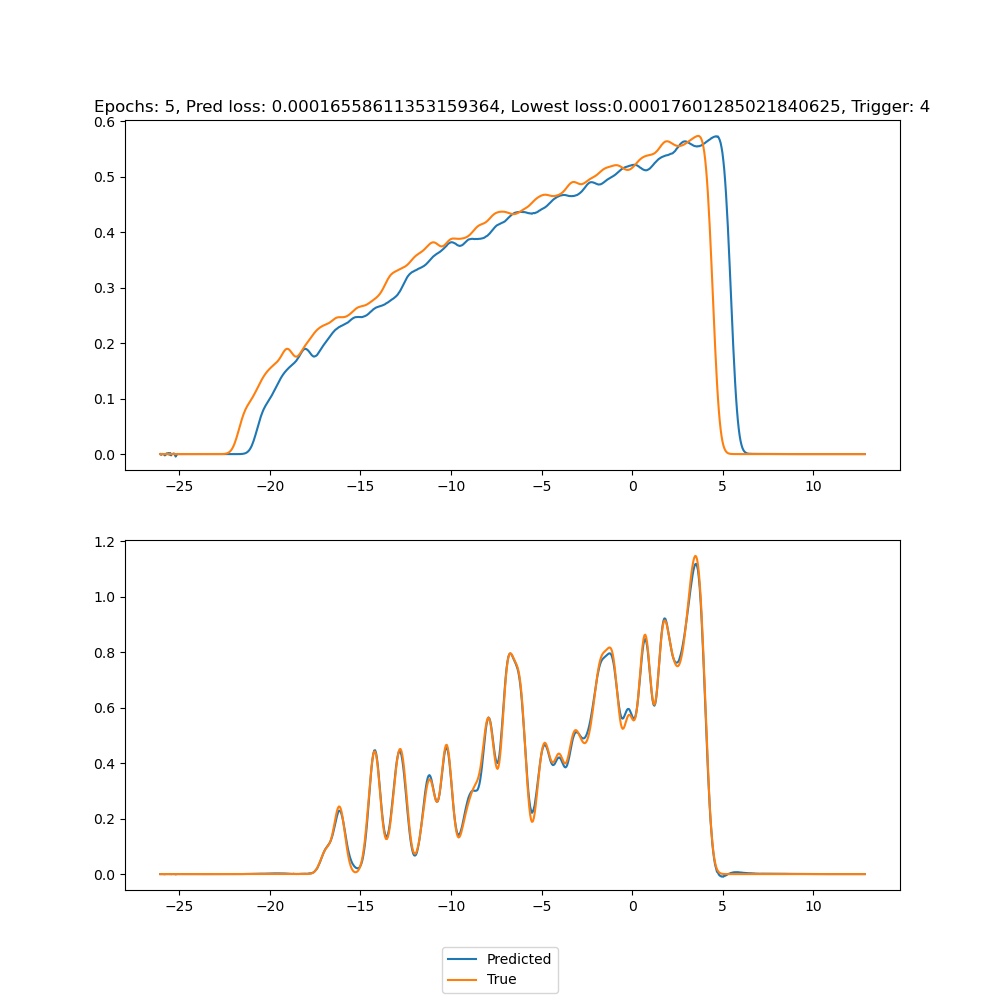

Epoch: 0:   0%|                                                                                                                          | 0/100 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

tensor([0.0005, 0.0005, 0.0005, 0.0006, 0.0007, 0.0008, 0.0010, 0.0012, 0.0014,
        0.0017, 0.0019, 0.0022, 0.0025, 0.0029, 0.0032, 0.0036, 0.0040, 0.0043,
        0.0047, 0.0051, 0.0056, 0.0060, 0.0064, 0.0068, 0.0072, 0.0077, 0.0081,
        0.0085, 0.0089, 0.0094, 0.0098, 0.0102, 0.0107, 0.0111, 0.0115, 0.0119,
        0.0124, 0.0128, 0.0132, 0.0137, 0.0141], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0010, 0.0012, 0.0014,
        0.0017, 0.0019, 0.0022, 0.0025, 0.0029, 0.0032, 0.0036, 0.0040, 0.0043,
        0.0047, 0.0052, 0.0056, 0.0060, 0.0064, 0.0068, 0.0072, 0.0077, 0.0081,
        0.0085, 0.0090, 0.0094, 0.0098, 0.0102, 0.0107, 0.0111, 0.0115, 0.0120,
        0.0124, 0.0128, 0.0133, 0.0137, 0.0142], grad_fn=<MeanBackward1>)
tensor([8.2447e-05, 9.7582e-05, 1.5213e-04, 2.4530e-04, 3.7583e-04, 5.4209e-04,
        7.4213e-04, 9.7374e-04, 1.2346e-03, 1.5221e-03, 1.8338e-03, 2.1671e-03,
        2.5197e-03, 2.8892e-03, 3.2733e-03, 3.6701e-

tensor([1.0116e-06, 2.1970e-05, 8.5595e-05, 1.9101e-04, 3.3680e-04, 5.2108e-04,
        7.4154e-04, 9.9558e-04, 1.2803e-03, 1.5929e-03, 1.9302e-03, 2.2892e-03,
        2.6672e-03, 3.0614e-03, 3.4694e-03, 3.8888e-03, 4.3177e-03, 4.7544e-03,
        5.1973e-03, 5.6451e-03, 6.0969e-03, 6.5517e-03, 7.0088e-03, 7.4677e-03,
        7.9279e-03, 8.3891e-03, 8.8511e-03, 9.3137e-03, 9.7768e-03, 1.0240e-02,
        1.0705e-02, 1.1169e-02, 1.1634e-02, 1.2100e-02, 1.2567e-02, 1.3035e-02,
        1.3503e-02, 1.3973e-02, 1.4444e-02, 1.4917e-02, 1.5391e-02],
       grad_fn=<MeanBackward1>)
tensor([8.8553e-07, 2.1888e-05, 8.5582e-05, 1.9109e-04, 3.3700e-04, 5.2142e-04,
        7.4205e-04, 9.9627e-04, 1.2812e-03, 1.5940e-03, 1.9315e-03, 2.2908e-03,
        2.6690e-03, 3.0634e-03, 3.4716e-03, 3.8912e-03, 4.3204e-03, 4.7572e-03,
        5.2003e-03, 5.6484e-03, 6.1003e-03, 6.5552e-03, 7.0124e-03, 7.4714e-03,
        7.9318e-03, 8.3931e-03, 8.8552e-03, 9.3180e-03, 9.7812e-03, 1.0245e-02,
        1.0709e-02,

Epoch: 1:   1%|█                                                                                                      | 1/100 [00:00<01:30,  1.09it/s, lowest_loss=0.000176, pred_loss=0.000175, trigger=0]

tensor([2.2284e-07, 2.1565e-05, 8.5795e-05, 1.9204e-04, 3.3886e-04, 5.2438e-04,
        7.4626e-04, 1.0019e-03, 1.2883e-03, 1.6027e-03, 1.9418e-03, 2.3028e-03,
        2.6826e-03, 3.0787e-03, 3.4885e-03, 3.9097e-03, 4.3403e-03, 4.7785e-03,
        5.2229e-03, 5.6722e-03, 6.1252e-03, 6.5812e-03, 7.0394e-03, 7.4994e-03,
        7.9606e-03, 8.4228e-03, 8.8858e-03, 9.3494e-03, 9.8134e-03, 1.0278e-02,
        1.0743e-02, 1.1209e-02, 1.1675e-02, 1.2142e-02, 1.2609e-02, 1.3078e-02,
        1.3547e-02, 1.4018e-02, 1.4490e-02, 1.4964e-02, 1.5439e-02],
       grad_fn=<MeanBackward1>)
tensor([4.3886e-07, 2.1616e-05, 8.5598e-05, 1.9151e-04, 3.3792e-04, 5.2295e-04,
        7.4427e-04, 9.9925e-04, 1.2850e-03, 1.5987e-03, 1.9371e-03, 2.2973e-03,
        2.6764e-03, 3.0717e-03, 3.4807e-03, 3.9012e-03, 4.3311e-03, 4.7687e-03,
        5.2124e-03, 5.6611e-03, 6.1136e-03, 6.5692e-03, 7.0270e-03, 7.4865e-03,
        7.9473e-03, 8.4092e-03, 8.8718e-03, 9.3351e-03, 9.7989e-03, 1.0263e-02,
        1.0728e-02,

tensor([4.8531e-07, 2.1821e-05, 8.5982e-05, 1.9209e-04, 3.3872e-04, 5.2397e-04,
        7.4552e-04, 1.0007e-03, 1.2867e-03, 1.6006e-03, 1.9391e-03, 2.2995e-03,
        2.6787e-03, 3.0742e-03, 3.4833e-03, 3.9038e-03, 4.3337e-03, 4.7713e-03,
        5.2150e-03, 5.6636e-03, 6.1161e-03, 6.5715e-03, 7.0292e-03, 7.4886e-03,
        7.9494e-03, 8.4111e-03, 8.8736e-03, 9.3368e-03, 9.8004e-03, 1.0265e-02,
        1.0729e-02, 1.1194e-02, 1.1660e-02, 1.2127e-02, 1.2594e-02, 1.3062e-02,
        1.3531e-02, 1.4001e-02, 1.4473e-02, 1.4946e-02, 1.5421e-02],
       grad_fn=<MeanBackward1>)
tensor([4.7036e-07, 2.1815e-05, 8.5990e-05, 1.9211e-04, 3.3876e-04, 5.2406e-04,
        7.4564e-04, 1.0009e-03, 1.2869e-03, 1.6008e-03, 1.9394e-03, 2.2998e-03,
        2.6791e-03, 3.0745e-03, 3.4837e-03, 3.9042e-03, 4.3342e-03, 4.7718e-03,
        5.2155e-03, 5.6642e-03, 6.1166e-03, 6.5721e-03, 7.0298e-03, 7.4893e-03,
        7.9500e-03, 8.4118e-03, 8.8743e-03, 9.3375e-03, 9.8012e-03, 1.0265e-02,
        1.0730e-02,

Epoch: 2:   2%|██                                                                                                     | 2/100 [00:01<01:31,  1.08it/s, lowest_loss=0.000176, pred_loss=0.000172, trigger=1]

tensor([4.8981e-07, 2.1911e-05, 8.6180e-05, 1.9242e-04, 3.3919e-04, 5.2464e-04,
        7.4637e-04, 1.0018e-03, 1.2880e-03, 1.6020e-03, 1.9408e-03, 2.3013e-03,
        2.6807e-03, 3.0763e-03, 3.4855e-03, 3.9061e-03, 4.3362e-03, 4.7738e-03,
        5.2176e-03, 5.6663e-03, 6.1188e-03, 6.5743e-03, 7.0320e-03, 7.4915e-03,
        7.9522e-03, 8.4140e-03, 8.8766e-03, 9.3397e-03, 9.8034e-03, 1.0268e-02,
        1.0732e-02, 1.1197e-02, 1.1663e-02, 1.2130e-02, 1.2597e-02, 1.3065e-02,
        1.3534e-02, 1.4004e-02, 1.4476e-02, 1.4949e-02, 1.5424e-02],
       grad_fn=<MeanBackward1>)
tensor([4.7389e-07, 2.1942e-05, 8.6279e-05, 1.9259e-04, 3.3946e-04, 5.2502e-04,
        7.4686e-04, 1.0024e-03, 1.2887e-03, 1.6029e-03, 1.9418e-03, 2.3024e-03,
        2.6819e-03, 3.0776e-03, 3.4870e-03, 3.9077e-03, 4.3378e-03, 4.7755e-03,
        5.2194e-03, 5.6682e-03, 6.1207e-03, 6.5762e-03, 7.0340e-03, 7.4935e-03,
        7.9543e-03, 8.4161e-03, 8.8787e-03, 9.3419e-03, 9.8056e-03, 1.0270e-02,
        1.0734e-02,

tensor([3.3772e-07, 2.1507e-05, 8.5502e-05, 1.9144e-04, 3.3790e-04, 5.2299e-04,
        7.4438e-04, 9.9945e-04, 1.2853e-03, 1.5990e-03, 1.9375e-03, 2.2978e-03,
        2.6770e-03, 3.0724e-03, 3.4815e-03, 3.9021e-03, 4.3321e-03, 4.7698e-03,
        5.2136e-03, 5.6624e-03, 6.1150e-03, 6.5706e-03, 7.0285e-03, 7.4882e-03,
        7.9492e-03, 8.4111e-03, 8.8739e-03, 9.3373e-03, 9.8012e-03, 1.0266e-02,
        1.0730e-02, 1.1196e-02, 1.1662e-02, 1.2129e-02, 1.2596e-02, 1.3064e-02,
        1.3534e-02, 1.4004e-02, 1.4476e-02, 1.4950e-02, 1.5424e-02],
       grad_fn=<MeanBackward1>)
tensor([3.4320e-07, 2.1448e-05, 8.5369e-05, 1.9123e-04, 3.3760e-04, 5.2259e-04,
        7.4388e-04, 9.9884e-04, 1.2846e-03, 1.5982e-03, 1.9366e-03, 2.2968e-03,
        2.6759e-03, 3.0712e-03, 3.4803e-03, 3.9008e-03, 4.3307e-03, 4.7683e-03,
        5.2122e-03, 5.6609e-03, 6.1135e-03, 6.5691e-03, 7.0270e-03, 7.4867e-03,
        7.9477e-03, 8.4097e-03, 8.8725e-03, 9.3358e-03, 9.7998e-03, 1.0264e-02,
        1.0729e-02,

Epoch: 3:   3%|███                                                                                                    | 3/100 [00:02<01:37,  1.01s/it, lowest_loss=0.000176, pred_loss=0.000169, trigger=2]

tensor([3.2318e-07, 2.1400e-05, 8.5296e-05, 1.9113e-04, 3.3749e-04, 5.2246e-04,
        7.4373e-04, 9.9869e-04, 1.2845e-03, 1.5980e-03, 1.9364e-03, 2.2966e-03,
        2.6757e-03, 3.0711e-03, 3.4801e-03, 3.9006e-03, 4.3306e-03, 4.7682e-03,
        5.2121e-03, 5.6608e-03, 6.1135e-03, 6.5691e-03, 7.0271e-03, 7.4868e-03,
        7.9478e-03, 8.4099e-03, 8.8727e-03, 9.3362e-03, 9.8001e-03, 1.0265e-02,
        1.0730e-02, 1.1195e-02, 1.1661e-02, 1.2128e-02, 1.2595e-02, 1.3064e-02,
        1.3533e-02, 1.4004e-02, 1.4476e-02, 1.4949e-02, 1.5424e-02])
tensor(0)
tensor(-1.0013)
tensor([3.2318e-07, 2.1400e-05, 8.5296e-05, 1.9113e-04, 3.3749e-04, 5.2246e-04,
        7.4373e-04, 9.9869e-04, 1.2845e-03, 1.5980e-03, 1.9364e-03, 2.2966e-03,
        2.6757e-03, 3.0711e-03, 3.4801e-03, 3.9006e-03, 4.3306e-03, 4.7682e-03,
        5.2121e-03, 5.6608e-03, 6.1135e-03, 6.5691e-03, 7.0271e-03, 7.4868e-03,
        7.9478e-03, 8.4099e-03, 8.8727e-03, 9.3362e-03, 9.8001e-03, 1.0265e-02,
        1.0730e-02, 1.119

tensor([2.8823e-07, 2.1600e-05, 8.5825e-05, 1.9200e-04, 3.3871e-04, 5.2410e-04,
        7.4579e-04, 1.0012e-03, 1.2874e-03, 1.6015e-03, 1.9403e-03, 2.3009e-03,
        2.6804e-03, 3.0761e-03, 3.4855e-03, 3.9063e-03, 4.3365e-03, 4.7743e-03,
        5.2183e-03, 5.6672e-03, 6.1199e-03, 6.5756e-03, 7.0336e-03, 7.4933e-03,
        7.9543e-03, 8.4163e-03, 8.8791e-03, 9.3426e-03, 9.8065e-03, 1.0271e-02,
        1.0736e-02, 1.1201e-02, 1.1668e-02, 1.2134e-02, 1.2602e-02, 1.3070e-02,
        1.3540e-02, 1.4011e-02, 1.4483e-02, 1.4956e-02, 1.5431e-02],
       grad_fn=<MeanBackward1>)
tensor([2.9234e-07, 2.1610e-05, 8.5843e-05, 1.9202e-04, 3.3876e-04, 5.2417e-04,
        7.4591e-04, 1.0013e-03, 1.2876e-03, 1.6017e-03, 1.9406e-03, 2.3012e-03,
        2.6807e-03, 3.0765e-03, 3.4859e-03, 3.9067e-03, 4.3369e-03, 4.7748e-03,
        5.2188e-03, 5.6677e-03, 6.1204e-03, 6.5760e-03, 7.0340e-03, 7.4937e-03,
        7.9547e-03, 8.4167e-03, 8.8795e-03, 9.3430e-03, 9.8069e-03, 1.0271e-02,
        1.0736e-02,

Epoch: 4:   4%|████                                                                                                   | 4/100 [00:04<01:46,  1.11s/it, lowest_loss=0.000176, pred_loss=0.000168, trigger=3]

tensor([3.1246e-07, 2.1651e-05, 8.5899e-05, 1.9212e-04, 3.3894e-04, 5.2446e-04,
        7.4635e-04, 1.0019e-03, 1.2883e-03, 1.6025e-03, 1.9416e-03, 2.3024e-03,
        2.6821e-03, 3.0779e-03, 3.4874e-03, 3.9083e-03, 4.3386e-03, 4.7765e-03,
        5.2206e-03, 5.6695e-03, 6.1222e-03, 6.5779e-03, 7.0359e-03, 7.4956e-03,
        7.9566e-03, 8.4187e-03, 8.8815e-03, 9.3450e-03, 9.8090e-03, 1.0273e-02,
        1.0739e-02, 1.1204e-02, 1.1670e-02, 1.2137e-02, 1.2605e-02, 1.3073e-02,
        1.3543e-02, 1.4014e-02, 1.4486e-02, 1.4960e-02, 1.5435e-02],
       grad_fn=<MeanBackward1>)
tensor([3.0158e-07, 2.1649e-05, 8.5896e-05, 1.9216e-04, 3.3902e-04, 5.2458e-04,
        7.4656e-04, 1.0022e-03, 1.2887e-03, 1.6030e-03, 1.9421e-03, 2.3030e-03,
        2.6828e-03, 3.0787e-03, 3.4883e-03, 3.9092e-03, 4.3396e-03, 4.7776e-03,
        5.2217e-03, 5.6706e-03, 6.1234e-03, 6.5791e-03, 7.0371e-03, 7.4969e-03,
        7.9579e-03, 8.4200e-03, 8.8829e-03, 9.3464e-03, 9.8104e-03, 1.0275e-02,
        1.0740e-02,

tensor([5.3829e-07, 2.1155e-05, 8.4644e-05, 1.9027e-04, 3.3635e-04, 5.2112e-04,
        7.4228e-04, 9.9721e-04, 1.2831e-03, 1.5968e-03, 1.9354e-03, 2.2959e-03,
        2.6754e-03, 3.0712e-03, 3.4807e-03, 3.9018e-03, 4.3322e-03, 4.7704e-03,
        5.2147e-03, 5.6639e-03, 6.1169e-03, 6.5729e-03, 7.0311e-03, 7.4910e-03,
        7.9522e-03, 8.4144e-03, 8.8773e-03, 9.3408e-03, 9.8049e-03, 1.0269e-02,
        1.0734e-02, 1.1200e-02, 1.1666e-02, 1.2133e-02, 1.2601e-02, 1.3070e-02,
        1.3539e-02, 1.4010e-02, 1.4483e-02, 1.4956e-02, 1.5432e-02],
       grad_fn=<MeanBackward1>)
tensor([1.6469e-07, 2.1523e-05, 8.5788e-05, 1.9215e-04, 3.3904e-04, 5.2461e-04,
        7.4655e-04, 1.0022e-03, 1.2887e-03, 1.6031e-03, 1.9422e-03, 2.3031e-03,
        2.6830e-03, 3.0790e-03, 3.4886e-03, 3.9097e-03, 4.3402e-03, 4.7783e-03,
        5.2226e-03, 5.6717e-03, 6.1247e-03, 6.5806e-03, 7.0388e-03, 7.4987e-03,
        7.9600e-03, 8.4222e-03, 8.8852e-03, 9.3489e-03, 9.8131e-03, 1.0278e-02,
        1.0743e-02,

Epoch: 5:   5%|█████▏                                                                                                 | 5/100 [00:05<02:03,  1.30s/it, lowest_loss=0.000176, pred_loss=0.000165, trigger=4]

tensor([1.6950e-07, 2.1575e-05, 8.5890e-05, 1.9228e-04, 3.3922e-04, 5.2484e-04,
        7.4683e-04, 1.0025e-03, 1.2891e-03, 1.6035e-03, 1.9427e-03, 2.3037e-03,
        2.6835e-03, 3.0795e-03, 3.4892e-03, 3.9104e-03, 4.3408e-03, 4.7790e-03,
        5.2232e-03, 5.6724e-03, 6.1253e-03, 6.5812e-03, 7.0394e-03, 7.4993e-03,
        7.9605e-03, 8.4227e-03, 8.8857e-03, 9.3493e-03, 9.8135e-03, 1.0278e-02,
        1.0743e-02, 1.1209e-02, 1.1675e-02, 1.2142e-02, 1.2610e-02, 1.3079e-02,
        1.3548e-02, 1.4019e-02, 1.4491e-02, 1.4965e-02, 1.5440e-02],
       grad_fn=<MeanBackward1>)
tensor([1.6935e-07, 2.1570e-05, 8.5880e-05, 1.9227e-04, 3.3920e-04, 5.2482e-04,
        7.4680e-04, 1.0025e-03, 1.2891e-03, 1.6035e-03, 1.9426e-03, 2.3036e-03,
        2.6835e-03, 3.0795e-03, 3.4892e-03, 3.9103e-03, 4.3408e-03, 4.7789e-03,
        5.2232e-03, 5.6723e-03, 6.1253e-03, 6.5812e-03, 7.0394e-03, 7.4993e-03,
        7.9605e-03, 8.4227e-03, 8.8857e-03, 9.3493e-03, 9.8134e-03, 1.0278e-02,
        1.0743e-02,

tensor([2.0223e-07, 2.1692e-05, 8.6082e-05, 1.9249e-04, 3.3949e-04, 5.2515e-04,
        7.4717e-04, 1.0029e-03, 1.2894e-03, 1.6038e-03, 1.9430e-03, 2.3039e-03,
        2.6837e-03, 3.0797e-03, 3.4893e-03, 3.9103e-03, 4.3407e-03, 4.7788e-03,
        5.2229e-03, 5.6720e-03, 6.1248e-03, 6.5807e-03, 7.0388e-03, 7.4986e-03,
        7.9598e-03, 8.4220e-03, 8.8849e-03, 9.3485e-03, 9.8126e-03, 1.0277e-02,
        1.0742e-02, 1.1208e-02, 1.1674e-02, 1.2141e-02, 1.2609e-02, 1.3077e-02,
        1.3547e-02, 1.4018e-02, 1.4490e-02, 1.4963e-02, 1.5438e-02],
       grad_fn=<MeanBackward1>)
tensor([4.4221e-07, 2.1857e-05, 8.6154e-05, 1.9246e-04, 3.3936e-04, 5.2494e-04,
        7.4691e-04, 1.0026e-03, 1.2892e-03, 1.6037e-03, 1.9431e-03, 2.3043e-03,
        2.6845e-03, 3.0809e-03, 3.4910e-03, 3.9126e-03, 4.3436e-03, 4.7822e-03,
        5.2269e-03, 5.6764e-03, 6.1297e-03, 6.5860e-03, 7.0444e-03, 7.5044e-03,
        7.9657e-03, 8.4280e-03, 8.8909e-03, 9.3544e-03, 9.8183e-03, 1.0283e-02,
        1.0748e-02,

Epoch: 6:   6%|██████▏                                                                                                | 6/100 [00:07<02:16,  1.45s/it, lowest_loss=0.000176, pred_loss=0.000164, trigger=5]

tensor([1.3661e-07, 2.1663e-05, 8.6129e-05, 1.9267e-04, 3.3981e-04, 5.2566e-04,
        7.4789e-04, 1.0039e-03, 1.2907e-03, 1.6054e-03, 1.9448e-03, 2.3061e-03,
        2.6862e-03, 3.0825e-03, 3.4924e-03, 3.9137e-03, 4.3444e-03, 4.7827e-03,
        5.2272e-03, 5.6764e-03, 6.1295e-03, 6.5856e-03, 7.0438e-03, 7.5039e-03,
        7.9652e-03, 8.4275e-03, 8.8905e-03, 9.3542e-03, 9.8185e-03, 1.0283e-02,
        1.0748e-02, 1.1214e-02, 1.1680e-02, 1.2147e-02, 1.2615e-02, 1.3084e-02,
        1.3554e-02, 1.4024e-02, 1.4497e-02, 1.4970e-02, 1.5445e-02],
       grad_fn=<MeanBackward1>)
tensor([1.3424e-07, 2.1659e-05, 8.6127e-05, 1.9267e-04, 3.3981e-04, 5.2567e-04,
        7.4791e-04, 1.0039e-03, 1.2907e-03, 1.6054e-03, 1.9449e-03, 2.3061e-03,
        2.6863e-03, 3.0826e-03, 3.4926e-03, 3.9139e-03, 4.3446e-03, 4.7829e-03,
        5.2274e-03, 5.6767e-03, 6.1298e-03, 6.5858e-03, 7.0441e-03, 7.5041e-03,
        7.9655e-03, 8.4278e-03, 8.8908e-03, 9.3545e-03, 9.8188e-03, 1.0283e-02,
        1.0749e-02,

tensor([1.4369e-07, 2.1612e-05, 8.6000e-05, 1.9243e-04, 3.3947e-04, 5.2520e-04,
        7.4731e-04, 1.0031e-03, 1.2898e-03, 1.6044e-03, 1.9437e-03, 2.3048e-03,
        2.6848e-03, 3.0809e-03, 3.4907e-03, 3.9120e-03, 4.3426e-03, 4.7808e-03,
        5.2251e-03, 5.6744e-03, 6.1274e-03, 6.5833e-03, 7.0416e-03, 7.5015e-03,
        7.9628e-03, 8.4250e-03, 8.8880e-03, 9.3516e-03, 9.8158e-03, 1.0280e-02,
        1.0746e-02, 1.1211e-02, 1.1678e-02, 1.2145e-02, 1.2612e-02, 1.3081e-02,
        1.3551e-02, 1.4021e-02, 1.4494e-02, 1.4967e-02, 1.5442e-02],
       grad_fn=<MeanBackward1>)
tensor([1.2816e-07, 2.1577e-05, 8.5951e-05, 1.9237e-04, 3.3941e-04, 5.2515e-04,
        7.4727e-04, 1.0031e-03, 1.2898e-03, 1.6044e-03, 1.9437e-03, 2.3049e-03,
        2.6849e-03, 3.0811e-03, 3.4909e-03, 3.9122e-03, 4.3428e-03, 4.7811e-03,
        5.2254e-03, 5.6747e-03, 6.1277e-03, 6.5838e-03, 7.0420e-03, 7.5020e-03,
        7.9633e-03, 8.4256e-03, 8.8887e-03, 9.3524e-03, 9.8166e-03, 1.0281e-02,
        1.0747e-02,

Epoch: 6:   6%|██████▏                                                                                                | 6/100 [00:08<02:20,  1.50s/it, lowest_loss=0.000176, pred_loss=0.000164, trigger=5]

tensor([1.2886e-07, 2.1575e-05, 8.5946e-05, 1.9236e-04, 3.3940e-04, 5.2513e-04,
        7.4725e-04, 1.0031e-03, 1.2898e-03, 1.6043e-03, 1.9437e-03, 2.3048e-03,
        2.6848e-03, 3.0810e-03, 3.4909e-03, 3.9121e-03, 4.3427e-03, 4.7810e-03,
        5.2254e-03, 5.6746e-03, 6.1277e-03, 6.5837e-03, 7.0419e-03, 7.5019e-03,
        7.9632e-03, 8.4255e-03, 8.8886e-03, 9.3523e-03, 9.8165e-03, 1.0281e-02,
        1.0746e-02, 1.1212e-02, 1.1679e-02, 1.2146e-02, 1.2614e-02, 1.3082e-02,
        1.3552e-02, 1.4023e-02, 1.4495e-02, 1.4969e-02, 1.5444e-02],
       grad_fn=<MeanBackward1>)


KeyboardInterrupt: 

In [184]:
M_soap.load_state_dict(default_state)

lr = 1
n_epochs = 100
traindata_loader = train_dataloader_soap
zero_alignment = 0

opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)

threshold = 30
scheduler_threshold = 5
tol = 1e-4


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
best_state = copy.deepcopy(M_soap.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))
fig, ax_list = plt.subplots(2,1)
critical_indexes = np.array([0,1])
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
ax_list = ax_list.flatten()
ax_list.flatten()
lines = []
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "Prediction")
    lines.append(line)
    ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "True")
fig.legend(labels = ["Predicted", "True"], loc = "lower center")
fig.show()
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in traindata_loader:
        opt.zero_grad()
        x_data, y_data = x_data.to(M_soap.device), y_data.to(M_soap.device)
        def closure(predictions = False):
            """
            Function is necessary for LBFGS, returns the total loss of the model

            Args:
                predictions (bool, optional): Returns prediction loss if true, returns total loss if False

            Returns:
                tensor: Loss
            """
            opt.zero_grad()
            _pred = M_soap.forward(x_data)
            zero_loss, zero_alignment = t_get_BF_shift_index_mse(_pred[0], y_data[0], shift_range, xdos = M_soap.xdos, perc = False)
            zero_loss *= 1e7
            _pred_loss = loss.t_get_mse(_pred[1:], y_data[1:])#, self.xdos), perc = True)       
            _pred_loss *= 1e7
            #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
            _pred_loss += zero_loss
            _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
            _reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
            _reg_loss *= M_soap.reg.item()
            _new_loss = _pred_loss + _reg_loss
            _new_loss.backward()
            # global z 
            # z = (torch.sum(abs(self.linear.weight.grad)))
            if predictions:
                return _pred_loss
            return _new_loss
        opt.step(closure)
            #print (z)
    with torch.no_grad():
        
        pred = M_soap.forward(x_data)
        zero_loss, zero_alignment = t_get_BF_shift_index_mse(pred[0], y_data[0], shift_range, xdos = M_soap.xdos, perc = False)
        print (zero_alignment)
        print (shift_range[zero_alignment])
        pred_loss = loss.t_get_mse(pred[1:], y_data[1:])#, self.alignment, self.xdos, perc = True)
        reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
        reg_loss *= M_soap.reg.item()
        new_loss = pred_loss + reg_loss + zero_loss
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            M_soap.load_state_dict(best_state)
            opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)
        if epoch %10 == 1:
            loss_history.append(lowest_loss.item())
            scheduler.step(new_loss)
        for i in range(len(critical_indexes)):
        #lines[i].set_ydata(structure_results[i].detach().cpu())
            lines[i].set_ydata(pred[i])
        ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

    with torch.no_grad():

        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(M_soap.state_dict())
            lowest_loss = new_loss
            trigger = 0

        else:
            trigger +=1

            if trigger > threshold:
                M_soap.load_state_dict(best_state)
                print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                break


<IPython.core.display.Javascript object>


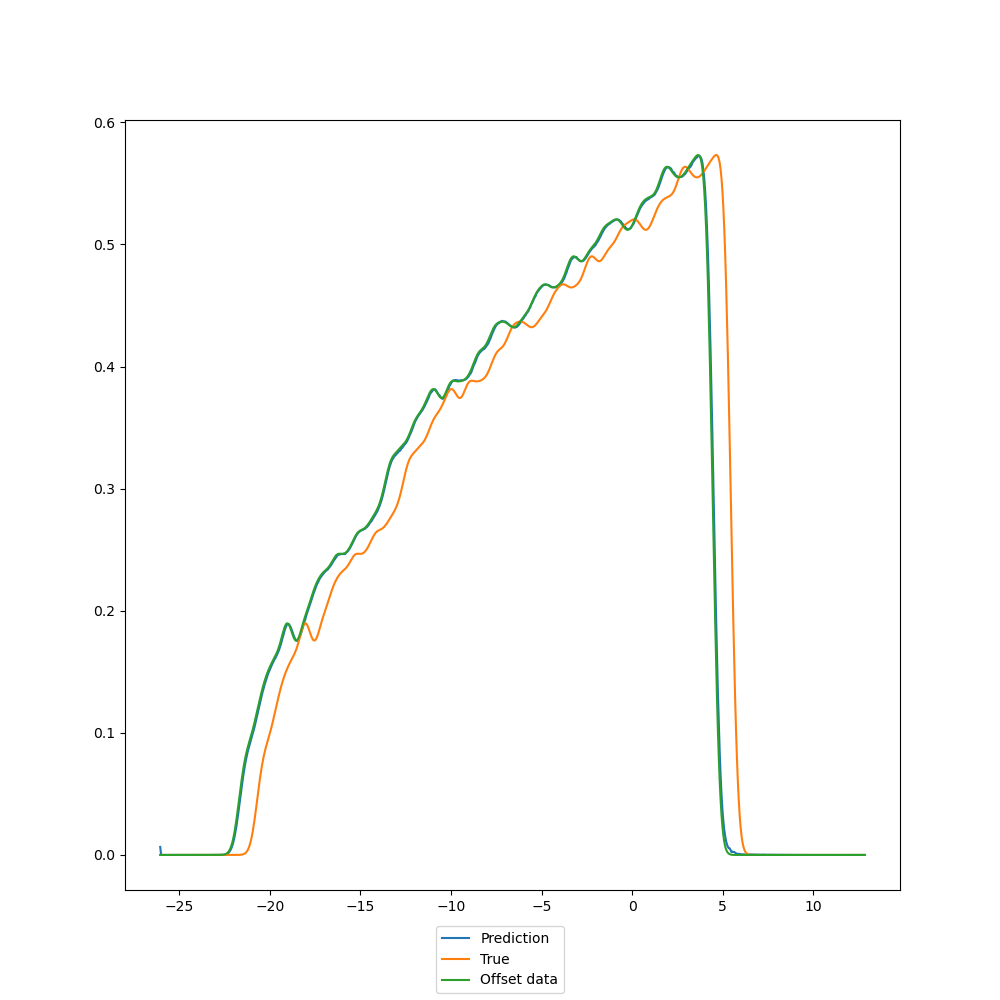

In [227]:
fig, ax = plt.subplots(1,1)
ax.plot(xdos, pred[0], label = "Prediction")
ax.plot(xdos, ldos[train_index[0]], label = "True")
ax.plot(xdos, y_shifted[train_index[0]], label = "Offset data")
fig.legend(loc="lower center")

### Jitter Test

In [219]:
def t_get_jitter_mse(prediction, true, shifts, shift_interval, xdos = None, perc = False):
    if xdos is not None:
        if len(prediction.shape)> 1:
            mse = torch.zeros(true.shape[0])
            new_shifts = torch.zeros_like(shifts)
            xdos_step = xdos[1] - xdos[0]
            shift_range = torch.clamp(torch.vstack([shifts + x for x in range(-1*shift_interval, shift_interval +1)]).T, -778, 778)* xdos_step
            if perc:
                mean = true.mean(axis = 0)
                std = torch.sqrt(torch.trapezoid((true - mean)**2, xdos, axis=1)).mean()
            else:
                std = None
            for i, pred in enumerate(prediction):
                shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[1],1), xdos, shift_range[i])
                mse[i], index = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[1],1), xdos = xdos, perc = perc, std_dev = std),0)
                new_shifts[i] = shift_range[i][index]

            mse = torch.mean(mse, 0)  
        else:
            mse = torch.zeros(1)
            new_shifts = torch.zeros(1)
            xdos_step = xdos[1] - xdos[0]
            shift_range = torch.clamp(torch.vstack([shifts + x for x in range(-1*shift_interval, shift_interval +1)]).T, -778, 778)* xdos_step                 
            if perc:
                raise ValueError("Cannot do percentage error for 1 sample")
            else:
                std = None
            shifted_preds = consistency.shifted_ldos(prediction.repeat(shift_range.shape[1],1), xdos, shift_range[0])
            error_range = loss.t_get_each_mse(shifted_preds, true.repeat(shift_range.shape[1],1), xdos = None, perc = perc, std_dev = std)
            mse, index = torch.min(error_range,0)
            new_shifts = shift_range[0][index]
        return mse, new_shifts/xdos_step
    else:
        raise ValueError("xdos not defined")

  0%|                                                                                                                                                                               | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


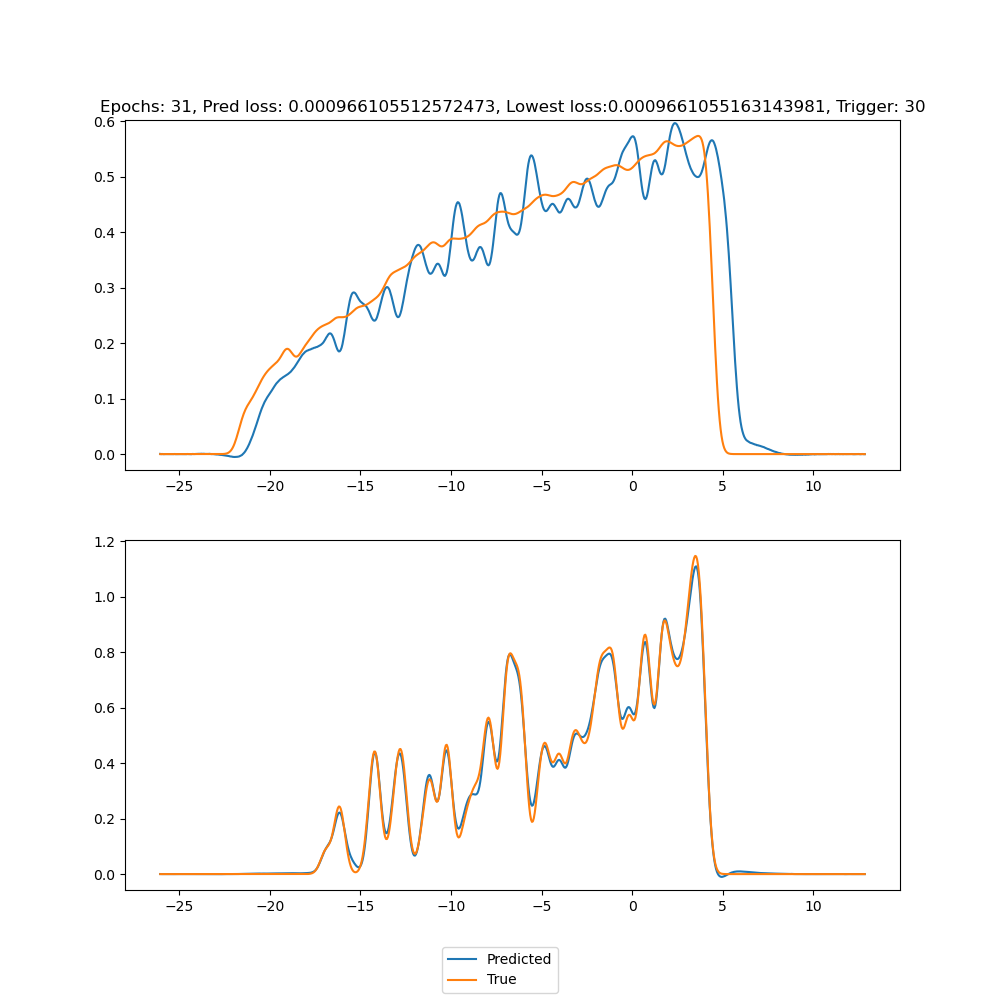

Epoch: 0:   0%|                                                                                                                           | 0/40 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

tensor(-1.)
tensor(-1.0013)


Epoch: 2:   5%|█████▏                                                                                                  | 2/40 [00:01<00:18,  2.00it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=1]

tensor(-2.)
tensor(-1.0013)
tensor(-3.)
tensor(-1.0013)


Epoch: 4:  10%|██████████▍                                                                                             | 4/40 [00:01<00:10,  3.49it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=3]

tensor(-4.)
tensor(-1.0013)
tensor(-5.)
tensor(-1.0013)


Epoch: 6:  15%|███████████████▌                                                                                        | 6/40 [00:01<00:06,  4.93it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=5]

tensor(-6.)
tensor(-1.0013)
tensor(-7.)
tensor(-1.0013)


Epoch: 8:  20%|████████████████████▊                                                                                   | 8/40 [00:02<00:05,  5.53it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=7]

tensor(-8.)
tensor(-1.0013)
tensor(-9.)
tensor(-1.0013)


Epoch: 10:  25%|█████████████████████████▌                                                                            | 10/40 [00:02<00:05,  5.55it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=9]

tensor(-10.)
tensor(-1.0013)
tensor(-11.)
tensor(-1.0013)


Epoch: 12:  30%|██████████████████████████████▎                                                                      | 12/40 [00:02<00:04,  5.86it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=11]

tensor(-12.)
tensor(-1.0013)
tensor(-13.)
tensor(-1.0013)


Epoch: 14:  35%|███████████████████████████████████▎                                                                 | 14/40 [00:03<00:04,  5.79it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=13]

tensor(-14.)
tensor(-1.0013)
tensor(-15.)
tensor(-1.0013)


Epoch: 16:  40%|████████████████████████████████████████▍                                                            | 16/40 [00:03<00:04,  5.39it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=15]

tensor(-16.)
tensor(-1.0013)


Epoch: 17:  42%|██████████████████████████████████████████▉                                                          | 17/40 [00:03<00:04,  5.12it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=16]

tensor(-17.)
tensor(-1.0013)
tensor(-18.)
tensor(-1.0013)


Epoch: 19:  48%|███████████████████████████████████████████████▉                                                     | 19/40 [00:04<00:03,  5.28it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=18]

tensor(-19.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 21:  52%|█████████████████████████████████████████████████████                                                | 21/40 [00:04<00:03,  5.33it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=20]

tensor(-20.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 23:  57%|██████████████████████████████████████████████████████████                                           | 23/40 [00:04<00:03,  5.38it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=22]

tensor(-20.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 25:  62%|███████████████████████████████████████████████████████████████▏                                     | 25/40 [00:05<00:02,  5.45it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=24]

tensor(-20.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 27:  68%|████████████████████████████████████████████████████████████████████▏                                | 27/40 [00:05<00:02,  5.41it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=26]

tensor(-20.)
tensor(-1.0013)


Epoch: 28:  70%|██████████████████████████████████████████████████████████████████████▋                              | 28/40 [00:05<00:02,  5.21it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=27]

tensor(-20.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 30:  75%|███████████████████████████████████████████████████████████████████████████▊                         | 30/40 [00:06<00:01,  5.26it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=29]

tensor(-20.)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)


Epoch: 31:  78%|██████████████████████████████████████████████████████████████████████████████▎                      | 31/40 [00:06<00:01,  4.72it/s, lowest_loss=0.000966, pred_loss=0.000232, trigger=30]

tensor(-20.)
tensor(-1.0013)
Implemented early stopping with lowest_loss: 0.0009661055163143981


In [230]:
M_soap.load_state_dict(default_state)
lr = 0.00001
n_epochs = 40
traindata_loader = train_dataloader_soap
zero_alignment = torch.tensor(0)
zero_alignment2 = torch.tensor(0)
shift_interval = 1


opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)

threshold = 30
scheduler_threshold = 5
tol = 1e-4


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
best_state = copy.deepcopy(M_soap.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))
fig, ax_list = plt.subplots(2,1)
critical_indexes = np.array([0,1])
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
ax_list = ax_list.flatten()
ax_list.flatten()
lines = []
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "Prediction")
    lines.append(line)
    ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "True")
fig.legend(labels = ["Predicted", "True"], loc = "lower center")
fig.show()
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in traindata_loader:
        opt.zero_grad()
        x_data, y_data = x_data.to(M_soap.device), y_data.to(M_soap.device)
        def closure(predictions = False):
            global zero_alignment2
            """
            Function is necessary for LBFGS, returns the total loss of the model

            Args:
                predictions (bool, optional): Returns prediction loss if true, returns total loss if False

            Returns:
                tensor: Loss
            """
            opt.zero_grad()
            _pred = M_soap.forward(x_data)
            zero_loss, zero_alignment2 = t_get_jitter_mse(_pred[0], y_data[0], zero_alignment, shift_interval, xdos = M_soap.xdos, perc = False)
            zero_loss *= 1e7
            _pred_loss = loss.t_get_mse(_pred[1:], y_data[1:])#, self.xdos), perc = True)       
            _pred_loss *= 1e7
            #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
            _pred_loss += zero_loss
            _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
            _reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
            _reg_loss *= M_soap.reg.item()
            _new_loss = _pred_loss + _reg_loss
            _new_loss.backward()
            # global z 
            # z = (torch.sum(abs(self.linear.weight.grad)))
            if predictions:
                return _pred_loss
            return _new_loss
        opt.step(closure)
            #print (z)
    with torch.no_grad():
        
        pred = M_soap.forward(x_data)
        zero_alignment = copy.deepcopy(zero_alignment2)
        zero_loss, best_alignment = t_get_BF_shift_index_mse(pred[0], y_data[0], shift_range, xdos = M_soap.xdos, perc = False)
        print (zero_alignment)
        print (shift_range[best_alignment])
        pred_loss = loss.t_get_mse(pred[1:], y_data[1:])#, self.alignment, self.xdos, perc = True)
        reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
        reg_loss *= M_soap.reg.item()
        new_loss = pred_loss + reg_loss + zero_loss
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            M_soap.load_state_dict(best_state)
            opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)
        if epoch %10 == 1:
            loss_history.append(lowest_loss.item())
            scheduler.step(new_loss)
        for i in range(len(critical_indexes)):
        #lines[i].set_ydata(structure_results[i].detach().cpu())
            lines[i].set_ydata(pred[i])
        ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

    with torch.no_grad():

        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(M_soap.state_dict())
            lowest_loss = new_loss
            trigger = 0

        else:
            trigger +=1

            if trigger > threshold:
                M_soap.load_state_dict(best_state)
                print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                break


<IPython.core.display.Javascript object>


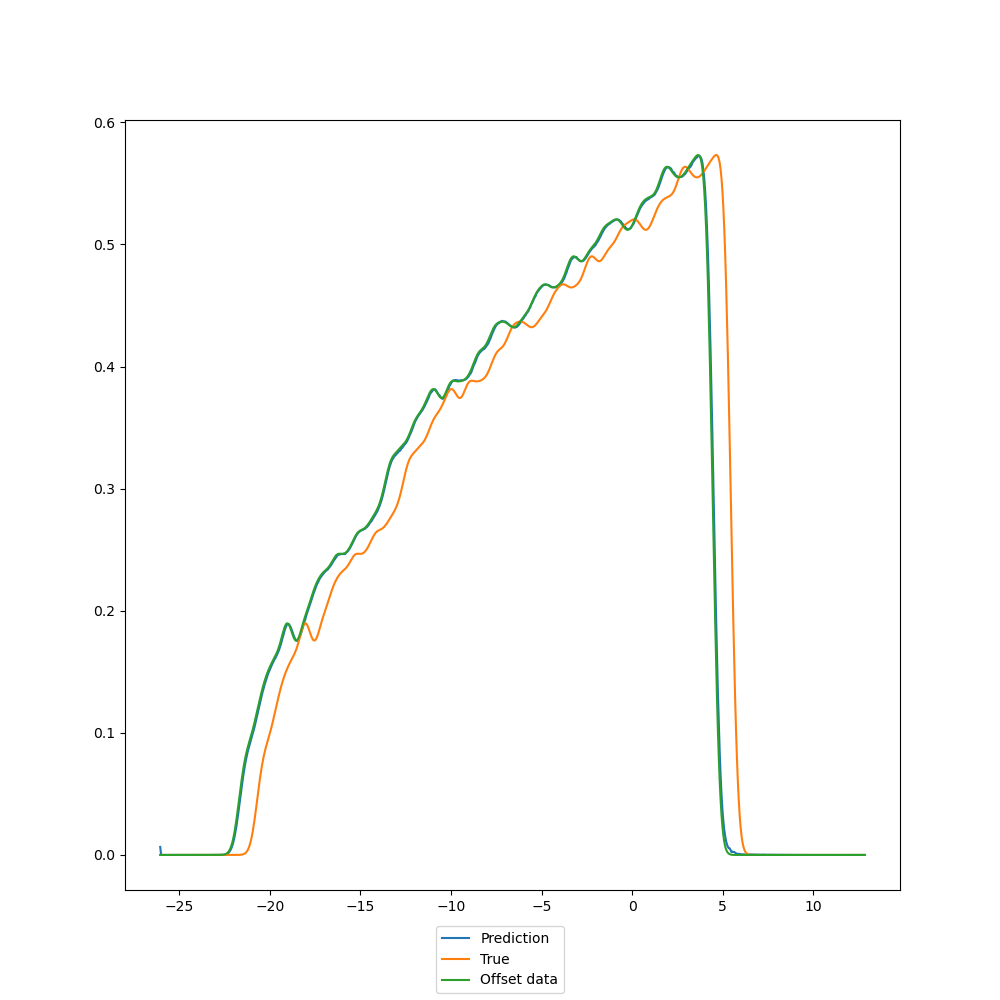

In [228]:
fig, ax = plt.subplots(1,1)
ax.plot(xdos, pred[0], label = "Prediction")
ax.plot(xdos, ldos[train_index[0]], label = "True")
ax.plot(xdos, y_shifted[train_index[0]], label = "Offset data")
fig.legend(loc="lower center")

  0%|                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


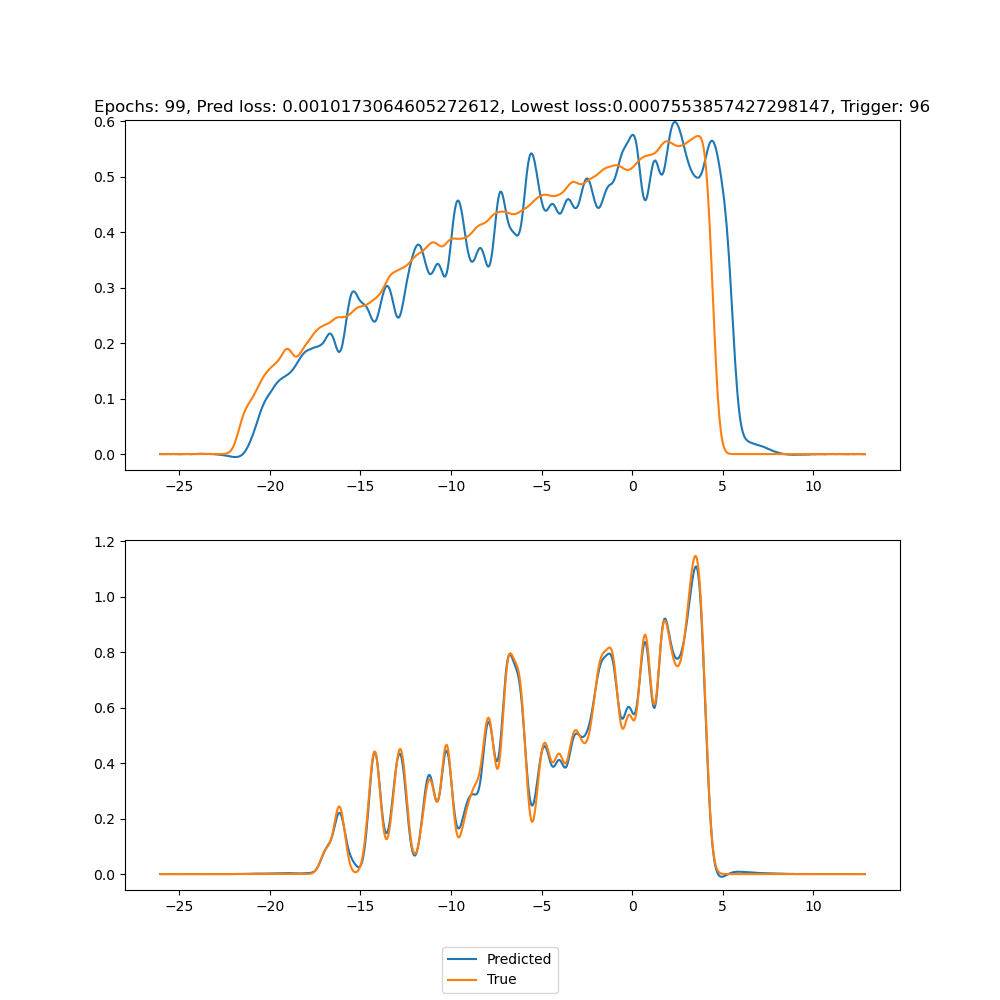

Epoch: 0:   0%|                                                                                                                          | 0/100 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

tensor(-1.)
tensor(-0.0501)
tensor(-1.0013)


Epoch: 1:   1%|█                                                                                                       | 1/100 [00:00<00:37,  2.64it/s, lowest_loss=0.00143, pred_loss=0.000273, trigger=0]

tensor(-2.)
tensor(-0.1001)
tensor(-1.0013)


Epoch: 2:   3%|███                                                                                                    | 3/100 [00:00<00:25,  3.82it/s, lowest_loss=0.000976, pred_loss=0.000259, trigger=0]

tensor(-3.)
tensor(-0.1502)
tensor(-1.0013)


Epoch: 3:   3%|███                                                                                                    | 3/100 [00:00<00:25,  3.82it/s, lowest_loss=0.000755, pred_loss=0.000263, trigger=0]

tensor(-4.)
tensor(-0.2003)
tensor(-1.0013)


Epoch: 5:   5%|█████▏                                                                                                 | 5/100 [00:01<00:20,  4.68it/s, lowest_loss=0.000755, pred_loss=0.000249, trigger=2]

tensor(-5.)
tensor(-0.2503)
tensor(-1.0013)
tensor(-6.)
tensor(-0.3004)
tensor(-1.0013)


Epoch: 7:   7%|███████▏                                                                                               | 7/100 [00:01<00:19,  4.89it/s, lowest_loss=0.000755, pred_loss=0.000247, trigger=4]

tensor(-7.)
tensor(-0.3505)
tensor(-1.0013)
tensor(-8.)
tensor(-0.4005)
tensor(-1.0013)


Epoch: 9:   9%|█████████▎                                                                                             | 9/100 [00:02<00:18,  4.79it/s, lowest_loss=0.000755, pred_loss=0.000245, trigger=6]

tensor(-9.)
tensor(-0.4506)
tensor(-1.0013)


Epoch: 10:  10%|██████████                                                                                           | 10/100 [00:02<00:18,  4.74it/s, lowest_loss=0.000755, pred_loss=0.000238, trigger=7]

tensor(-10.)
tensor(-0.5006)
tensor(-1.0013)
tensor(-11.)
tensor(-0.5507)
tensor(-1.0013)


Epoch: 12:  12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.57it/s, lowest_loss=0.000755, pred_loss=0.000238, trigger=8]

tensor(-12.)
tensor(-0.6008)
tensor(-1.0013)


Epoch: 12:  12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.57it/s, lowest_loss=0.000755, pred_loss=0.000242, trigger=9]

tensor(-13.)
tensor(-0.6508)
tensor(-1.0013)


Epoch: 13:  13%|█████████████                                                                                       | 13/100 [00:02<00:19,  4.50it/s, lowest_loss=0.000755, pred_loss=0.000243, trigger=10]

tensor(-14.)
tensor(-0.7009)
tensor(-1.0013)


Epoch: 14:  14%|██████████████                                                                                      | 14/100 [00:03<00:19,  4.52it/s, lowest_loss=0.000755, pred_loss=0.000238, trigger=11]

tensor(-15.)
tensor(-0.7510)
tensor(-1.0013)


Epoch: 16:  16%|████████████████                                                                                    | 16/100 [00:03<00:18,  4.51it/s, lowest_loss=0.000755, pred_loss=0.000236, trigger=13]

tensor(-16.)
tensor(-0.8010)
tensor(-1.0013)
tensor(-17.)

Epoch: 17:  17%|█████████████████                                                                                   | 17/100 [00:03<00:18,  4.60it/s, lowest_loss=0.000755, pred_loss=0.000238, trigger=14]


tensor(-0.8511)
tensor(-1.0013)


Epoch: 18:  18%|██████████████████                                                                                  | 18/100 [00:04<00:17,  4.66it/s, lowest_loss=0.000755, pred_loss=0.000238, trigger=15]

tensor(-18.)
tensor(-0.9012)
tensor(-1.0013)


Epoch: 19:  19%|███████████████████                                                                                 | 19/100 [00:04<00:17,  4.71it/s, lowest_loss=0.000755, pred_loss=0.000235, trigger=16]

tensor(-19.)
tensor(-0.9512)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 21:  21%|█████████████████████                                                                               | 21/100 [00:04<00:17,  4.61it/s, lowest_loss=0.000755, pred_loss=0.000234, trigger=18]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 22:  22%|██████████████████████                                                                              | 22/100 [00:04<00:16,  4.66it/s, lowest_loss=0.000755, pred_loss=0.000235, trigger=19]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 23:  23%|███████████████████████                                                                             | 23/100 [00:05<00:16,  4.70it/s, lowest_loss=0.000755, pred_loss=0.000235, trigger=20]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 24:  24%|████████████████████████                                                                            | 24/100 [00:05<00:16,  4.71it/s, lowest_loss=0.000755, pred_loss=0.000234, trigger=21]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 25:  25%|█████████████████████████                                                                           | 25/100 [00:05<00:15,  4.74it/s, lowest_loss=0.000755, pred_loss=0.000233, trigger=22]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 26:  26%|██████████████████████████                                                                          | 26/100 [00:05<00:15,  4.71it/s, lowest_loss=0.000755, pred_loss=0.000233, trigger=23]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 27:  27%|███████████████████████████                                                                         | 27/100 [00:05<00:15,  4.71it/s, lowest_loss=0.000755, pred_loss=0.000234, trigger=24]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 28:  28%|████████████████████████████                                                                        | 28/100 [00:06<00:15,  4.73it/s, lowest_loss=0.000755, pred_loss=0.000233, trigger=25]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 30:  30%|██████████████████████████████                                                                      | 30/100 [00:06<00:14,  4.71it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=27]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 31:  31%|███████████████████████████████                                                                     | 31/100 [00:06<00:14,  4.74it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=28]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 32:  32%|████████████████████████████████                                                                    | 32/100 [00:06<00:14,  4.77it/s, lowest_loss=0.000755, pred_loss=0.000233, trigger=29]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 33:  33%|█████████████████████████████████                                                                   | 33/100 [00:07<00:13,  5.07it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=30]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 35:  35%|███████████████████████████████████                                                                 | 35/100 [00:07<00:11,  5.90it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=32]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 37:  37%|█████████████████████████████████████                                                               | 37/100 [00:07<00:09,  6.40it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=34]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 39:  39%|███████████████████████████████████████                                                             | 39/100 [00:08<00:09,  6.51it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=36]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 41:  41%|█████████████████████████████████████████                                                           | 41/100 [00:08<00:08,  6.63it/s, lowest_loss=0.000755, pred_loss=0.000232, trigger=38]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 43:  43%|███████████████████████████████████████████                                                         | 43/100 [00:08<00:08,  6.59it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=40]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 45:  45%|█████████████████████████████████████████████                                                       | 45/100 [00:09<00:10,  5.48it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=42]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 46:  46%|██████████████████████████████████████████████                                                      | 46/100 [00:09<00:10,  5.27it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=43]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 47:  47%|███████████████████████████████████████████████                                                     | 47/100 [00:09<00:10,  5.10it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=43]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 48:  48%|████████████████████████████████████████████████                                                    | 48/100 [00:09<00:10,  4.92it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=44]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 49:  49%|█████████████████████████████████████████████████                                                   | 49/100 [00:09<00:10,  4.82it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=46]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 50:  50%|██████████████████████████████████████████████████                                                  | 50/100 [00:10<00:09,  5.25it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=47]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 52:  52%|████████████████████████████████████████████████████                                                | 52/100 [00:10<00:08,  5.99it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=49]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 54:  54%|██████████████████████████████████████████████████████                                              | 54/100 [00:10<00:07,  6.31it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=51]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 55:  56%|████████████████████████████████████████████████████████                                            | 56/100 [00:11<00:11,  3.67it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=52]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 56:  56%|████████████████████████████████████████████████████████                                            | 56/100 [00:11<00:11,  3.67it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=53]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 58:  58%|█████████████████████████████████████████████████████████▉                                          | 58/100 [00:11<00:10,  4.20it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=55]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 60:  60%|████████████████████████████████████████████████████████████                                        | 60/100 [00:12<00:09,  4.44it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=57]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 61:  61%|█████████████████████████████████████████████████████████████                                       | 61/100 [00:12<00:08,  4.50it/s, lowest_loss=0.000755, pred_loss=0.000231, trigger=58]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 62:  62%|██████████████████████████████████████████████████████████████▌                                      | 62/100 [00:12<00:08,  4.57it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=59]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 63:  63%|███████████████████████████████████████████████████████████████▋                                     | 63/100 [00:12<00:07,  4.64it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=60]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 64:  64%|████████████████████████████████████████████████████████████████▋                                    | 64/100 [00:13<00:07,  4.70it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=61]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 65:  65%|█████████████████████████████████████████████████████████████████▋                                   | 65/100 [00:13<00:07,  4.72it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=62]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 66:  66%|██████████████████████████████████████████████████████████████████▋                                  | 66/100 [00:13<00:07,  4.75it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=63]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 67:  67%|███████████████████████████████████████████████████████████████████▋                                 | 67/100 [00:13<00:06,  4.76it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=64]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 68:  68%|████████████████████████████████████████████████████████████████████▋                                | 68/100 [00:13<00:06,  4.77it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=65]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 69:  69%|█████████████████████████████████████████████████████████████████████▋                               | 69/100 [00:14<00:06,  4.78it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=66]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 70:  70%|██████████████████████████████████████████████████████████████████████▋                              | 70/100 [00:14<00:06,  4.81it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=67]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 71:  71%|███████████████████████████████████████████████████████████████████████▋                             | 71/100 [00:14<00:06,  4.80it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=68]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 72:  72%|████████████████████████████████████████████████████████████████████████▋                            | 72/100 [00:14<00:05,  4.79it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=69]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 73:  73%|█████████████████████████████████████████████████████████████████████████▋                           | 73/100 [00:14<00:05,  4.75it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=70]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 74:  74%|██████████████████████████████████████████████████████████████████████████▋                          | 74/100 [00:15<00:05,  4.79it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=71]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 75:  75%|███████████████████████████████████████████████████████████████████████████▊                         | 75/100 [00:15<00:05,  4.79it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=72]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 76:  76%|████████████████████████████████████████████████████████████████████████████▊                        | 76/100 [00:15<00:04,  4.83it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=73]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 77:  77%|█████████████████████████████████████████████████████████████████████████████▊                       | 77/100 [00:15<00:04,  4.80it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=74]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 78:  78%|██████████████████████████████████████████████████████████████████████████████▊                      | 78/100 [00:15<00:04,  4.83it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=75]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 79:  79%|███████████████████████████████████████████████████████████████████████████████▊                     | 79/100 [00:16<00:04,  4.83it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=76]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 80:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 80/100 [00:16<00:04,  4.82it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=77]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 81:  81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 81/100 [00:16<00:03,  4.84it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=78]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 82:  82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 82/100 [00:16<00:03,  4.86it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=79]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 83:  83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 83/100 [00:16<00:03,  4.85it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=80]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 84:  84%|████████████████████████████████████████████████████████████████████████████████████▊                | 84/100 [00:17<00:03,  4.84it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=81]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 85:  85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 85/100 [00:17<00:03,  4.81it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=82]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 86:  86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 86/100 [00:17<00:02,  4.84it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=83]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 87:  87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 87/100 [00:17<00:02,  4.86it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=84]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 88:  88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 88/100 [00:18<00:02,  4.86it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=85]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 89:  89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 89/100 [00:18<00:02,  4.88it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=86]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 90:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 90/100 [00:18<00:02,  4.89it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=87]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 91:  91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 91/100 [00:18<00:01,  4.89it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=88]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 92:  92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 92/100 [00:18<00:01,  4.90it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=89]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 93:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 93/100 [00:19<00:01,  4.94it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=90]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)


Epoch: 94:  94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:19<00:01,  4.92it/s, lowest_loss=0.000755, pred_loss=0.00023, trigger=91]

tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)


Epoch: 95:  95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 95/100 [00:19<00:01,  4.91it/s, lowest_loss=0.000755, pred_loss=0.000229, trigger=92]

tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)


Epoch: 96:  96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:19<00:00,  4.95it/s, lowest_loss=0.000755, pred_loss=0.000229, trigger=93]

tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 98:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:20<00:00,  4.97it/s, lowest_loss=0.000755, pred_loss=0.000229, trigger=95]

tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)


Epoch: 99:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:20<00:00,  4.97it/s, lowest_loss=0.000755, pred_loss=0.000229, trigger=96]

tensor(-1.0013)
tensor(-1.0013)
tensor(-20.)
tensor(-1.0013)
tensor(-1.0013)


Epoch: 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s, lowest_loss=0.000755, pred_loss=0.000229, trigger=96]


In [229]:
M_soap.load_state_dict(default_state)
lr = 0.001
n_epochs = 100
traindata_loader = train_dataloader_soap
zero_alignment = torch.tensor(0)
zero_alignment2 = torch.tensor(0)
shift_interval = 1

opt = torch.optim.Adam(M_soap.parameters(), lr = lr, weight_decay = 1e-11)

threshold = 100
scheduler_threshold = 30
tol = 1e-4


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
best_state = copy.deepcopy(M_soap.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))
fig, ax_list = plt.subplots(2,1)
critical_indexes = np.array([0,1])
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
ax_list = ax_list.flatten()
ax_list.flatten()
lines = []
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "Prediction")
    lines.append(line)
    ax_list[i].plot(M_soap.xdos.cpu(), traindata_loader.dataset.tensors[1][i], label = "True")
fig.legend(labels = ["Predicted", "True"], loc = "lower center")
fig.show()
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in traindata_loader:
        opt.zero_grad()
        x_data, y_data = x_data.to(M_soap.device), y_data.to(M_soap.device)
        pred = M_soap.forward(x_data)
        zero_loss, zero_alignment = t_get_jitter_mse(pred[0], y_data[0], zero_alignment, shift_interval, M_soap.xdos)#, self.xdos, perc = True)
        print (zero_alignment)
        pred_loss = loss.t_get_mse(pred[1:], y_data[1:])
        new_loss = pred_loss + zero_loss
        pred_loss.backward()
        opt.step()
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            self.load_state_dict(best_state)
            opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
        if epoch %1000 == 1:
            loss_history.append(lowest_loss.item())
    with torch.no_grad():
        pred = M_soap.forward(x_data)
        zero_loss, best_alignment = t_get_BF_shift_index_mse(pred[0], y_data[0], shift_range, xdos = M_soap.xdos, perc = False)
        print (zero_alignment * xdos_step)
        print (shift_range[best_alignment])
        pred_loss = loss.t_get_mse(pred[1:], y_data[1:])#, self.alignment, self.xdos, perc = True)
        reg_loss = torch.sum(torch.pow(M_soap.linear.weight,2))
        reg_loss *= M_soap.reg.item()
        new_loss = pred_loss + reg_loss + zero_loss
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            M_soap.load_state_dict(best_state)
            opt = torch.optim.LBFGS(M_soap.parameters(), lr = lr)
        if epoch %10 == 1:
            loss_history.append(lowest_loss.item())
            scheduler.step(new_loss)
        for i in range(len(critical_indexes)):
    #lines[i].set_ydata(structure_results[i].detach().cpu())
            lines[i].set_ydata(pred[i])
        ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(M_soap.state_dict())
            lowest_loss = new_loss
            trigger = 0

        else:
            trigger +=1

            if trigger > threshold:
                M_soap.load_state_dict(best_state)
                print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                break


In [35]:
zero_alignment

NameError: name 'zero_alignment' is not defined